# Accessing, Analyzing, & Visualizing TEMPO data through ArcGIS Image Services Programmatically (Geometry Envelope)

## Overview
Selected TEMPO data have been processed into free, publicly available ArcGIS image services that provide pre-filtered, analysis-ready imagery/data.

This notebook illustrates the following:

* Choose a TEMPO image service to query
* Select a time period and geometry bounding box (envelope) of interest
* View data values for area of interest in a table
* Chart returned values for area of interest
* View imagery for the time period of interest in interactive mapper

**Why ArcGIS image services?** Each TEMPO ArcGIS image service is hosted at a service URL, which has several built-in functions provided through the [ArcGIS image service REST API](https://developers.arcgis.com/rest/services-reference/enterprise/image-service/). These functionalities can be accessed via webpage interfaces or called programatically, providing ways to access, analyze, and display the TEMPO data.

### Prerequisites
Note: ESRI software/licenses are NOT required to access the services via the interfaces or programatically. No GIS software is required to access these TEMPO image services (although there are many methods to use these services in GIS).

**Required:**
- Basic Python knowledge (variables, loops, functions)
- Familiarity with TEMPO instrument and data products (from previous ARSET presentations)

**Python Libraries:**
- [matplotlib](http://matplotlib.org/) - for creating plots and visualizations
- [numpy](https://numpy.org/) - for numerical operations
- [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet/blob/master/python/ipyleaflet/README.md) - for visualization in interactive mapper
- [requests](https://github.com/psf/requests) - for sending HTTP requests to service API


### Data & Scope
Each TEMPO ArcGIS image service has a portal page with detailed descriptions on the service, the filtering applied, geographic and temporal coverage, as well as access to the online map viewer to view the image service. It is strongly recommended to read over the service description to ensure understanding of the data.

The TEMPO image services are available in the Esri Living Atlas of the World:
* [NO2](https://www.arcgis.com/home/item.html?id=6a1bdd0c076d499da69e867732ed2ab7)
* [HCHO](https://www.arcgis.com/home/item.html?id=27947c9d5d5f417b8b46a9d75a084549)
* [Ozone Total](https://www.arcgis.com/home/item.html?id=b6a2f0ebfbbc424aa58ef13af0a3bd6c)

The example in this notebook uses:
- **Product**: TEMPO_NO2_L3_V03 (Level-3 gridded NO₂ tropopsheric column)
- **Resolution**: approximately 2.1 km × 4.4 km, hourly during daylight
- **Coverage**: North America
- **Example region**: Hampton Roads, Virginia

*Methods apply to other TEMPO products (formaldehyde, ozone, etc.) and regions within North America.*

### Notebook Author / Affiliation
- Author: Atmospheric Science Data Center
- Questions? Please post questions on the [NASA Earthdata Forum](https://forum.earthdata.nasa.gov/)

# Create Time Graph - ArcGIS Image Service: Get Samples

## 1. Setup
Install Python packages, as necessary (NOTE: Google Colab appears to have all the packages pre-installed)

In [1]:
# Install Python packages if not available
#!pip install --quiet ipywidgets nodejs traitlets numpy pandas matplotlib

Import Python libraries

In [2]:
# For accessing data and creating chart
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from datetime import datetime, timezone
import json

# For creating interactive mapper
from ipyleaflet import Map, ImageService, basemaps, WidgetControl
from ipywidgets import SelectionSlider, Layout, Label, VBox
from ipywidgets import Output, HTML

# Set dataframe view options to ensure all rows appear (optional)
pd.set_option("display.max_rows", None)

### Convert Human-Readable Dates to Milliseconds Since Epoch

The TEMPO image services store the timestamp of each data scan as a Unix timestamp (e.g., 1752582321), which is the number of seconds since January 1, 1970 UTC. As these integers are not intuitive, we will use two custom functions to convert between Unix timestamps and human-readable date time strings.


In [3]:
# function to take input time as string and convert to integer of seconds since unix epoch UTC (Jan 1, 1970)
def convert_to_milliseconds(date_time_str):
    """Converts a date-time string in 'YYYY-MM-DD HH:MM:SS' format to milliseconds since epoch."""
    inputDate = dt.datetime.strptime(date_time_str, "%Y-%m-%d %H:%M:%S")
    return int(inputDate.replace(tzinfo=timezone.utc).timestamp() * 1000)


# function to take input time as integer of seconds since unix epoch UTC (Jan 1, 1970) and convert to string in 'YYYY-MM-DDTHH:MM:SSZ' format
def convert_from_milliseconds(milliseconds_since_epoch):
    """Converts milliseconds since epoch to a date-time string in 'YYYY-MM-DDTHH:MM:SSZ' format."""
    inputDateMilli = datetime.fromtimestamp((milliseconds_since_epoch) / 1000, tz=timezone.utc)
    return inputDateMilli.strftime("%Y-%m-%dT%H:%M:%SZ")

## 2. User Selections
Users can select the variable, time window, and bounding box (Xmin, Ymin, Xmax, Ymax) of interest or use defaults.

### 2.1 Choose TEMPO product/variable of interest

Default is TEMPO NO₂ tropospheric column. (HCHO and Ozone are provided for reference; use one at a time.)

In [4]:
# NOTE: Use exactly one image_service_url + variable_name. Comment out others.

# Option 1: NO2 image service (default)
image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2930763263-LARC_CLOUD/TEMPO_NO2_L3_V03_HOURLY_TROPOSPHERIC_VERTICAL_COLUMN/ImageServer"
variable_name = "NO2_Troposphere"

# Option 2: Formaldehyde image service
# image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2930761273-LARC_CLOUD/TEMPO_HCHO_L3_V03_HOURLY_VERTICAL_COLUMN/ImageServer"
# variable_name = "HCHO"

# Option 3: Total Column Ozone
# image_service_url = "https://gis.earthdata.nasa.gov/image/rest/services/C2930764281-LARC_CLOUD/TEMPO_O3TOT_L3_V03_HOURLY_OZONE_COLUMN_AMOUNT/ImageServer"
# variable_name = "Ozone_Column_Amount"


### 2.2 Choose time period of interest

There are two options:
* Option 1 (default): Time period is yesterday (last 24 hours from present)
* Option 2: Manually select any time period within scope of TEMPO mission (August 2, 2023 - present)

NOTE: User must comment out (place a # at the beginning of the code line) the option that is not in use. By default, Option 2 is commented out.

In [5]:
# Choose starting and ending dates to run against

yesterday = dt.datetime.today() - dt.timedelta(days=1)
today = dt.datetime.today()

# Option 1 (Default): Yesterday - today NOTE: converts local computer time to UTC
# """Note: If using Option 2, comment out the two lines below:"""
# start_date_time_str = str(dt.datetime(yesterday.year, yesterday.month, yesterday.day))
# end_date_time_str = str(dt.datetime(today.year, today.month, today.day, today.hour))

# OR

# Option 2: Select specifc time period of interest'''
"""Note: If using Option 1, comment out the two lines below:"""
start_date_time_str = "2025-05-06 0:01:00" #in 'YYYY-MM-DD HH:MM:SS' format "2025-04-20 12:00:00"
end_date_time_str = "2025-05-07 05:00:00" #in 'YYYY-MM-DD HH:MM:SS' format "2025-05-25 12:00:00"

# Convert user input dates to milliseconds since epoch
start_time = convert_to_milliseconds(start_date_time_str)
end_time = convert_to_milliseconds(end_date_time_str)

print(
    f"The time period of interest has been defined as: Start = {start_date_time_str} ({start_time}); End: = {end_date_time_str} ({end_time})"
)

The time period of interest has been defined as: Start = 2025-05-06 0:01:00 (1746489660000); End: = 2025-05-07 05:00:00 (1746594000000)


### 2.3 Choose bounding box (envelope) of interest

Provide WGS84 (EPSG:4326) coordinates. Example below is Hampton Roads, VA area. Update as needed.

In [6]:
# Bounding box / geometry envelope in WGS84 (EPSG:4326)
xmin, ymin = -76.6, 37.1
xmax, ymax = -76.3, 37.3

geometry_envelope = {
    "xmin": xmin,
    "ymin": ymin,
    "xmax": xmax,
    "ymax": ymax,
    "spatialReference": {"wkid": 4326}
}
print("Geometry (xmin, ymin, xmax, ymax):", xmin, ymin, xmax, ymax)


Geometry (xmin, ymin, xmax, ymax): -76.6 37.1 -76.3 37.3


# 3. Identify number and timestamp of TEMPO scans in time period of interest

The timestamp of each TEMPO scan is stored as a dimension in the image service and can be accessed by sending a Multidimenaional Info request to the service URL.

In [7]:
# Create url for multidimensional info request
dim_info_url = f"{image_service_url}/multidimensionalInfo"

# Make request to service API
dim_info = requests.get(dim_info_url, params={"f": "json"}).json()
all_times = dim_info["multidimensionalInfo"]["variables"][0]["dimensions"][0]["values"]

# Filter to timestamps within the desired range and print count of scans found
timestamps = [t for t in all_times if start_time <= t <= end_time]
print("Number of TEMPO scans:", len(timestamps))

# Iterate through TEMPO scans and print timestamps as Unix epoch and date string
for t in timestamps:
    date_strings = convert_from_milliseconds(t)
    print(t, " ", date_strings)

Number of TEMPO scans: 15
1746489730000   2025-05-06T00:02:10Z
1746492138000   2025-05-06T00:42:18Z
1746530469000   2025-05-06T11:21:09Z
1746532877000   2025-05-06T12:01:17Z
1746535285000   2025-05-06T12:41:25Z
1746537693000   2025-05-06T13:21:33Z
1746540101000   2025-05-06T14:01:41Z
1746543701000   2025-05-06T15:01:41Z
1746547301000   2025-05-06T16:01:41Z
1746550901000   2025-05-06T17:01:41Z
1746554501000   2025-05-06T18:01:41Z
1746558101000   2025-05-06T19:01:41Z
1746561702000   2025-05-06T20:01:42Z
1746577599000   2025-05-07T00:26:39Z
1746578533000   2025-05-07T00:42:13Z


# 4. Retreive data values for area of interest for selected time period

Data values for a selected envelope can be accessed by sending a Get Samples request to the service URL and returned in a json.
The data are iterated through and values added to a dataframe.
The dataframe is then viewed as a table.

## 4.1 Send Get Samples request

In [8]:
base_url = f"{image_service_url}/getSamples/"

params = {
    "geometry": json.dumps(geometry_envelope),
    "geometryType": "esriGeometryEnvelope",
    "sampleDistance": "",              # optional thinning
    "sampleCount": "",                 # optional limit
    "mosaicRule": json.dumps({"multidimensionalDefinition":[{"variableName": variable_name}]}),
    "pixelSize": "",                   # e.g., "0.05" to coarsen, if desired
    "returnFirstValueOnly": "false",
    "interpolation": "RSP_BilinearInterpolation",  # for smoother columns; use NN for exact pixel values
    "outFields": "",
    "sliceId": "",
    "time": f"{start_time},{end_time}",
    "f": "pjson"
}

response = requests.get(base_url, params=params)
response.raise_for_status()
data = response.json()

### 4.2 Extract data into a dataframe

The returned json contains the variable, timestamps, and data values for the TEMPO scans in the selected time period. Not all scans in the selected time period may have data for the selected envelope. The retrieved data are iterated through to find which scans had data for the selected envelope and adding those data values with their corresponding timestamps to a dataframe. The dataframe is displayed in a table format.

In [9]:
# Extract relevant information into a DataFrame
samples = []
for sample in data.get("samples", []):
    attributes = sample.get("attributes", {})
    var_value = attributes.get(variable_name)

    # Only include the sample if it has a valid value for the variable of interest
    """Note: this will result in timeslices being excluded if there are no data within the
    bounding box. Code may be modified to see all timestamps (i.e., include TEMPO scans
    where there are no data)."""
    if var_value is not None:  # keep zeros as valid values
        try:
            samples.append(
                {
                    "StdTime": attributes["StdTime"],
                    variable_name: float(var_value),  # Convert to float
                }
            )
        except (TypeError, ValueError):
            # Skip if the value cannot be converted to float
            continue

# Convert the list to a DataFrame
df = pd.DataFrame(samples)

# Check if dataframe is empty. If not empty, convert StdTime from Unix timestamp (milliseconds) to datetime and print dataframe
if df.empty:
    print(
        f"No {variable_name} data found between {start_date_time_str} - {end_date_time_str} "
        f"for envelope ({xmin}, {ymin}, {xmax}, {ymax})."
    )
else:
    df["StdTime"] = pd.to_datetime(df["StdTime"], unit="ms")
    print(df)


                 StdTime  NO2_Troposphere
0    2025-05-06 11:21:09     1.447314e+15
1    2025-05-06 12:01:17     2.191788e+15
2    2025-05-06 12:41:25     1.305590e+15
3    2025-05-06 13:21:33     1.077239e+15
4    2025-05-06 14:01:41     2.533740e+15
5    2025-05-06 15:01:41     7.700356e+14
6    2025-05-06 16:01:41     2.253384e+15
7    2025-05-06 17:01:41    -2.503395e+14
8    2025-05-06 18:01:41     7.068411e+14
9    2025-05-06 19:01:41    -5.982827e+15
10   2025-05-06 20:01:42     2.472415e+15
11   2025-05-06 11:21:09     1.751305e+15
12   2025-05-06 12:01:17     2.915948e+15
13   2025-05-06 12:41:25     1.065988e+15
14   2025-05-06 13:21:33     1.170897e+15
15   2025-05-06 14:01:41     2.751154e+15
16   2025-05-06 15:01:41     8.164202e+14
17   2025-05-06 16:01:41     2.303832e+15
18   2025-05-06 17:01:41    -2.404040e+14
19   2025-05-06 18:01:41     1.146787e+15
20   2025-05-06 19:01:41    -5.577514e+15
21   2025-05-06 20:01:42     3.453638e+15
22   2025-05-06 11:21:09     2.357

### 4.3 Display the data in a chart

The data in the dataframe can be displayed in a chart. The chart can be exported for later use (this option is commented out by default).

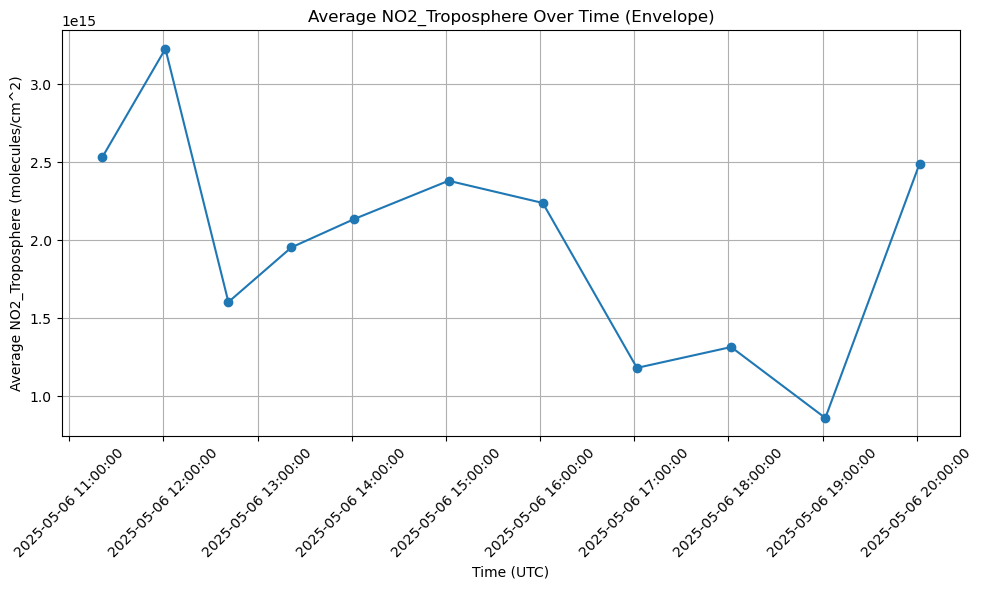

In [10]:
# Group by time to calculate the average value for each timestamp
df_avg = df.groupby("StdTime", as_index=False)[variable_name].mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_avg["StdTime"], df_avg[variable_name], marker="o", linestyle="-")

# Set title and labels--user may change
plt.title(f"Average {variable_name} Over Time (Envelope)")  # User may change title as desired
plt.xlabel("Time (UTC)")
plt.ylabel(
    f"Average {variable_name} (molecules/cm^2)"
)  # Change unit as needed for variable selected (e.g., Ozone total is Dobson units)

# Set grid, tick marks, and format
plt.grid(True)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
plt.xticks(rotation=45)
plt.tight_layout()

# Optional: Save the plot to a local folder (include file path). Format set to PNG as default but can be changed.
# plt.savefig("outputGraph.png", format="png")

# Show plot in notebook
plt.show()

# 5. Create an interactive mapper

This mapper includes all of the TEMPO scans within the selected time period. The viewer shows the entire scans (not just around the area of interest). The scans can be stepped through using the time slider. Users may zoom in/out on the map. Users can hover over the map to see coordinates. Users can click on the map to have the coordinate point display below the mapper.

NOTE: There is a known bug in Google Colab that limits the time slider to 5 or fewer timesteps in the slider. This notebook has two options for the slider. Option 1 (default), which is hardcoded to only show the first 5 timestamps to avoid this issue, and Option 2, which will show all of the timestamps in the user's selected time period.

In [11]:
# A handler that will update the map everytime the user moves the slider
def update_image(change):
    tempo_image_service.time = [change.new, timestamps[4]]


# Function to define interactive map behavior
def on_click(**kwargs):
    """When a user clicks on the map, print coordinates below map"""
    if kwargs.get("type") == "click":
        print(str(kwargs.get("coordinates")))
    """When a user hovers mouse over map, display coordinates within map"""
    if kwargs.get("type") == "mousemove":
        latlng = kwargs.get("coordinates")
        lat, lng = latlng
        coordinates_label.value = f"Coordinates: ({lat:.5f}, {lng:.5f})"

In [12]:
# Initialize the map
m = Map(center=(47, -122), zoom=3, basemap=basemaps.Esri.WorldTopoMap)

# Set parameters for calling TEMPO image service
"""Note: The rendering_rule rasterFunction holds the colormap associated with the image service.
Replace with the appropriate colormap for best visualization depending on selected variable.
NO2: rendering_rule={"rasterFunction":"matter_RGB"},
HCHO: rendering_rule={"rasterFunction":"haline_RGB"},
Ozone Tot: rendering_rule={"rasterFunction":"batlow_RGB"}, """
tempo_image_service = ImageService(
    url=image_service_url,
    rendering_rule={"rasterFunction": "matter_RGB"},
    time=timestamps,
    format="jpgpng",
    opacity=0.5,
)

# Create a list with the user selected UTC times with time_values for easy visualization of time
time_strings = [convert_from_milliseconds(t) for t in timestamps]

# Create a list of tuples to input in SelectionSlider's options for easy visualization of time
# Option 1: If using Google Colab, use this time_options to account for a bug that occurs if more than 5 timeslices are called at a time
time_options = [(time_strings[i], timestamps[i]) for i in range(5)]

# Option 2: If not using Google Colab, use this time_options to call all timeslices
# time_options = [(time_strings[i], timestamps[i]) for i in range(len(timestamps))]

# Create the slider
slider = SelectionSlider(
    description="Time:", options=time_options, layout=Layout(width="700px", height="20px")
)
# slider = SelectionSlider(description='Time:', options=timestamps, layout=Layout(width='700px', height='20px'))

# Create a Label for the VBox
time_label = Label(value="Time Slider")

# Listens to the slider's user input and helps update the map
slider.observe(update_image, "value")

# create a VBox to contain the slider and be placed in the map
vbox = VBox([slider, time_label])

# Slider placed in bottomleft of the map
control = WidgetControl(widget=vbox, position="bottomleft")

# Output widget to listen to the user's mouse hovering over the map
output = Output()
controloutput = WidgetControl(widget=output, position="topright")

# Label widget to display coordinates
coordinates_label = HTML(value="Coordinates: ")
coordinates_control = WidgetControl(widget=coordinates_label, position="bottomright")

# Add all widgets to the map
m.add(tempo_image_service)
m.add(control)
m.add(controloutput)
m.add(coordinates_control)

# When user hovers over the map coordinates_label gets updated and prints the coordinates where clicked
m.on_interaction(on_click)

# Call map
m

Map(center=[47, -122], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…